In [1]:
import sys
sys.path.append("../")
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_algorithms.optimizers import SPSA, COBYLA
from sanchez_ansatz import SanchezAnsatz
from experiments.experiment_module import ExperimentModule
from experiments.create_state import get_state
from experiments.densities import compute_eta
from experiments.util import get_state_vector
from copy import deepcopy
from typing import Dict
import matplotlib.pyplot as plt

%matplotlib inline

In [102]:
class ReplicateOptModule: 
    
    def __init__(self, ansatz: QuantumCircuit, k0: int, init_params: np.ndarray, target_state: np.ndarray, maxiter: int = 100, learning_rate: float = 1.5, tol: float=1e-4):
        self._ansatz = ansatz
        self._num_qubits = ansatz.num_qubits
        self._init_params = init_params
        self._target_state = target_state
        self._maxiter = maxiter
        self._learning_rate = learning_rate
        self._k0 = k0
        self._tol = tol
        
    def _compute_state_vector(self, params):
        temp_ansatz = self._ansatz.assign_parameters(params)
        return get_state_vector(temp_ansatz)
    
    def loss(self, output_state: np.ndarray ,target_state: np.ndarray): 
        return np.mean(np.abs(output_state - target_state)**2)
    
    def _compute_partial(self, out_amp: float, amp_idx: int, param: float, param_idx: int, param_lvl: int):
        """
        Equation (34) from MARIN-SANCHEZ et al. (2021) arXiv:2111.07933

        Returns:
            float: the result of the partial
        """
        condition_1_1 = param_idx*2**(self._num_qubits - param_lvl + 1) <= amp_idx
        condition_1_2 = amp_idx < (param_idx + 1)*2**(self._num_qubits - param_lvl)
        
        condition_2_1 = (param_idx + 1)*2**(self._num_qubits - param_lvl) <= amp_idx
        condition_2_2 = amp_idx < (param_idx + 1)*2**(self._num_qubits - param_lvl + 1)
        
        if  condition_1_1 and condition_1_2:
            return -1/2 * np.sin(param/2)/np.cos(param/2) * out_amp
        if condition_2_1 and condition_2_2:
            return 1/2 * np.cos(param/2)/np.sin(param/2) * out_amp
        return 0
    
    def _loss_partial(self, output_state: np.ndarray, targ_state: np.ndarray, param: float, param_idx: int, param_lvl):
        diffs = []
        for amp_idx, (out_amp, targ_amp) in enumerate(zip(output_state, targ_state)):
            diff = 2*(out_amp - targ_amp)*self._compute_partial(out_amp, amp_idx, param, param_idx, param_lvl)
            diffs.append(diff)

        return np.mean(diff)
        
    def _opt_step(self, params: np.ndarray, output_state, targ_state)->np.ndarray:
        
        loss_derivatives = np.zeros((len(params),)).astype(np.complex64)

        # navigate unclustered angles
        for param_level in range(self._k0):
            # at each level we have exactly 2**param_level angles
            for param_idx in range(2**param_level):
                param = params[param_idx + 2**param_level - 1]
                loss_derivatives[param_idx + 2**param_level - 1] = self._loss_partial(output_state, targ_state, param, param_idx, param_level)


        # navigate unclustered angles
        clustered_parameters = self._num_qubits - self._k0

        # From the levels after k0, the number of parameters are equal to the number of qubits left
        for param_idx in range(clustered_parameters, self._num_qubits+1):
            param_level = param_idx - 1 
            
            param = params[param_idx]
            loss_derivatives[param_idx] = self._loss_partial(output_state, targ_state, param, param_idx, param_level)

        return np.abs(loss_derivatives)
    
    def minimize(self) -> Dict[float, np.ndarray]:
        """
        Implements algorithm 1 from MARIN-SANCHEZ et al. (2021) arXiv:2111.07933

        returns: 
            ndarray: Numpy ndarray with the optimized parameters 
        """

        params = deepcopy(self._init_params)
        output_state = self._compute_state_vector(params)
        
        previous_loss = 0
        computed_loss = self.loss(output_state, self._target_state)
        loss_difference = np.abs(computed_loss - previous_loss)

        total_iterations = 0
        while total_iterations < self._maxiter and loss_difference > self._tol:

            param_derivatives = self._opt_step(params, output_state, self._target_state)

            params = params - self._learning_rate*param_derivatives

            output_state = self._compute_state_vector(params)

            previous_loss = computed_loss
            computed_loss = self.loss(output_state, self._target_state)
            loss_difference = np.abs(computed_loss - previous_loss)

            total_iterations += 1

        return {"loss": computed_loss, "x": params}

        

In [103]:
num_qubits = 5
state_params = {"x_points": (0, 1), "loc": 0.5, "scale": 0.4}

normal_amplitudes = get_state(num_qubits, "normal", state_params)
eta = compute_eta("normal", density_params=state_params)

sanchez = SanchezAnsatz(normal_amplitudes, eps=0.05, eta=eta)

t_sanchez = transpile(sanchez, basis_gates=["u", "cx"])

In [84]:
t_sanchez.parameters

ParameterView([Parameter([0,0]_ry), Parameter([1,0]_ry), Parameter([1,1]_ry), Parameter([2,0]_ry), Parameter([2,1]_ry), Parameter([2,2]_ry), Parameter([2,3]_ry), Parameter([3]y), Parameter([4]y)])

In [104]:
custom_em = ReplicateOptModule(t_sanchez, sanchez.k0, sanchez.init_params, normal_amplitudes, maxiter=50, tol=1e-4)
result = custom_em.minimize()

Loss:  0.0003751552703917456


/home/ismael/anaconda3/envs/sanchez-env/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ismael/anaconda3/envs/sanchez-env/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


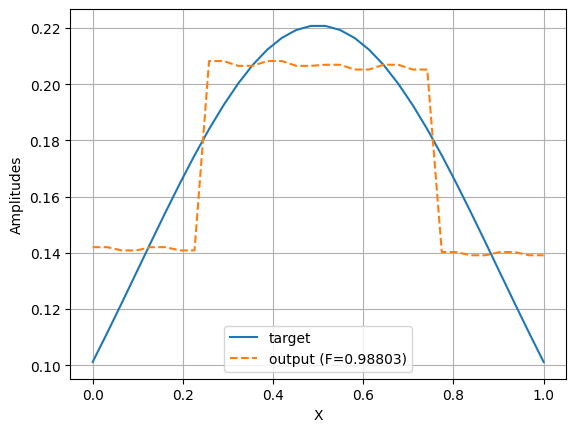

<Figure size 640x480 with 0 Axes>

In [105]:
print("Loss: " , result["loss"])
t_sanchez_p = t_sanchez.assign_parameters(result["x"])
output_state = get_state_vector(t_sanchez_p)

fid = np.abs(output_state @ normal_amplitudes)**2

x_points = np.linspace(0, 1, 2**num_qubits)
plt.plot(x_points, normal_amplitudes, label="target")
plt.plot(x_points, output_state, "--", label=f"output (F={np.round(fid, 5)})")
plt.savefig("../results/plot_custom_opt.png")
plt.xlabel("X")
plt.ylabel("Amplitudes")
plt.grid()
plt.legend(loc="best")
plt.show()
plt.clf()

### Normal distribution

In [138]:
interval = (0, 1) 
num_qubits = 8

scales = [1, 0.6, 0.4, 0.3]

target_states = []
approx_states = []

for scale in scales:

    state_params = {"x_points": interval, "loc": 0.5, "scale": scale}

    normal_amplitudes = get_state(num_qubits, "normal", state_params)
    eta = compute_eta("normal", density_params=state_params)

    sanchez = SanchezAnsatz(normal_amplitudes, eps=0.05, eta=eta)
    init_params = sanchez.init_params
    t_sanchez = transpile(sanchez, basis_gates=["u", "cx"])

    em = ExperimentModule(t_sanchez, COBYLA(tol=1e-9), target_state=normal_amplitudes, init_params=init_params,  device="GPU")

    res = em.minimize()

    t_sanchez = t_sanchez.assign_parameters(res.x)

    result_sv = get_state_vector(t_sanchez)
    
    target_states.append(normal_amplitudes)
    approx_states.append(result_sv)

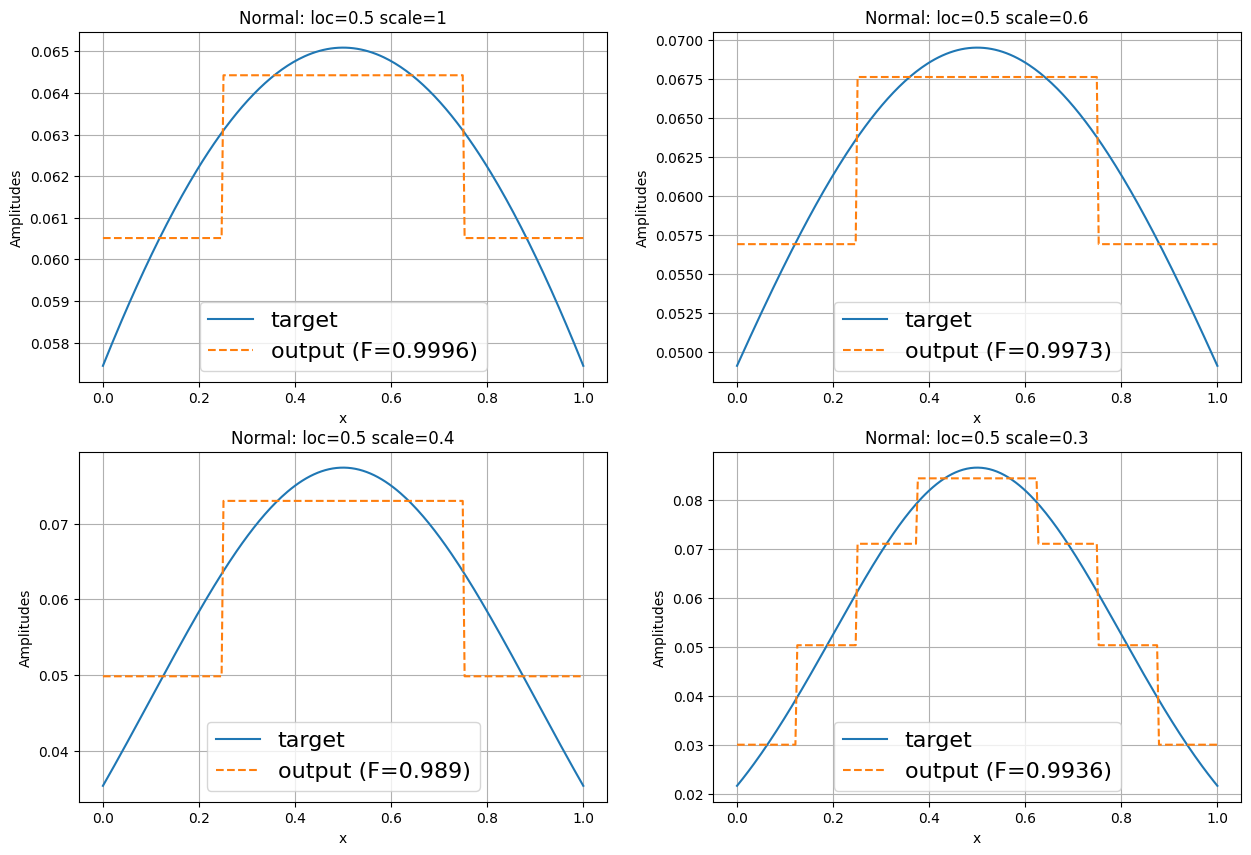

In [139]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

x_points = np.linspace(*interval, 2**num_qubits)

axes = axes.reshape(-1)

for (ax, targ_state, approx_state, sigma) in zip(axes, target_states, approx_states, scales):
    fid = np.abs(targ_state @ approx_state)**2
    ax.set_title(f"Normal: loc=0.5 scale={sigma}")
    ax.plot(x_points, targ_state, label="target")
    ax.plot(x_points, approx_state, "--", label=f"output (F={np.round(fid, 4)})")
    ax.set_xlabel("x")
    ax.set_ylabel("Amplitudes")
    ax.grid()
    ax.legend(loc="best", fontsize=16)

axes = axes.reshape(2, 2)
fig.savefig("../results/normal_dist.png")

### Black-Scholes

In [140]:
interval = (-10, 10)

state_params = {"x_points": interval, "K": 45, "c": 3}

num_qubits = 5
x_points = np.linspace(0, 2**num_qubits, 2**num_qubits)
black_scholes_state = get_state(num_qubits, "black-scholes", state_params)

sanchez = SanchezAnsatz(black_scholes_state, eps=0.05)
init_params = sanchez.init_params
t_sanchez = transpile(sanchez, basis_gates=["u", "cx"])

em = ExperimentModule(t_sanchez, COBYLA(tol=1e-9), target_state=black_scholes_state, init_params=init_params,  device="GPU")

res = em.minimize()

t_sanchez = t_sanchez.assign_parameters(res.x)

result_sv = get_state_vector(t_sanchez)

/tmp/ipykernel_58578/2253225782.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.bar(x_points, result_sv.astype(float),label=f"output (F={np.round(fid, 4)})")


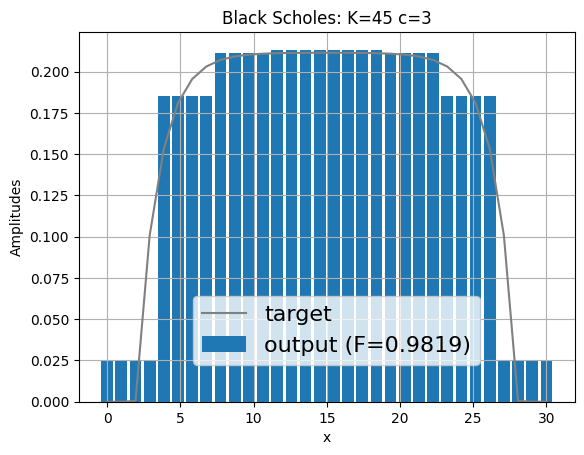

In [141]:
fid = np.abs(black_scholes_state @ result_sv)**2

x_points = np.linspace(0, 30, 2**num_qubits)
plt.title("Black Scholes: K=45 c=3")
plt.bar(x_points, result_sv.astype(float),label=f"output (F={np.round(fid, 4)})")
plt.plot(x_points, black_scholes_state, color="gray", label="target")
plt.grid()
plt.xlabel("x")
plt.ylabel("Amplitudes")
plt.legend(loc=(0.23, 0.1), fontsize=16) #(1.01, 0.9)
plt.savefig("../results/black_scholes.png")
plt.show()
